In [1]:
import numpy as np
import matplotlib.pyplot as plt
from z3 import *
import torch
import time
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from Z3_Tools import *
from utils import *
from models import * 

## (1) Z3 Logic 

In [2]:
s = Solver()
s.add(parse("A|B"))
s.add(parse("A->C"))
s.add(parse("B->C"))
s.add(Not(parse("C")))

print(s.check())

unsat


In [3]:
## Test Verifier 
known = ["A|B", "A->C"]
proposal = "C"

is_valid = verify_step(known, proposal)
print("Is the step valid?", is_valid)

Is the step valid? False


## (2) Enumerate Propositional Logic Statements

In [4]:
ALL_FORMULAS = ["A", "B", "C", "D",
                "~A", "~B", "~C",  "~D", 
                "A->B", "A->C", "B->C", "A->D", "B->D", "C->D",
                "B->A", "C->A", "C->B", "D->A", "D->B", "D->C",
                "A&B", "B&C", "A&C", "A&D", "B&D", "C&D", 
                "A|B", "B|C", "A|C", "A|D", "B|D", "C|D", ]

# Define ALL_STATES from many random subsets of ALL_FORMULAS
# Ignore false states (check this by ensuring a -> false is false, which means a is true) 
N = 6000; ALL_STATES = set(); 
while len(ALL_STATES) < N: 
    subset = frozenset(random_subset(ALL_FORMULAS, 1, 4))
    if not verify_step(list(subset), "A & ~A"): 
        ALL_STATES.add(subset)
print(len(ALL_STATES))

6000


In [5]:
total = len(ALL_STATES) * len(ALL_FORMULAS)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known = list(known)
    for prop in ALL_FORMULAS:
        label = verify_step(known, prop)
        
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(int(label))
        count += 1
        if count % 50000 == 0:
            print(f"{count} / {total} samples done")

50000 / 192000 samples done
100000 / 192000 samples done
150000 / 192000 samples done


In [6]:
print(X_states[5])
print(X_props[5])
print(Y_labels[5])

['B|C', 'A&D', 'A|C', 'B&D']
~B
0


In [7]:
## Can also save to .npz and load later ... 
# data = np.load("logic_dataset.npz")
# X_states = data["X_states"]
# X_props  = data["X_props"]
# Y        = data["Y"]

## (3) Train on Prop Logic 

In [8]:
# Define one-hot-encoding map and state encoder 
OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}

# Map X_props, X_states to One-Hot 
X_props_Map = np.array([OneHot_Map[p] for p in X_props])
X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_Map]  # basically defining a repeating list of I rows ... 
X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])

print(X_props[8])
print(X_props_Map[15])
print(X_props_1h[15])
print(X_states[15])
print(X_states_1h[5])

A->B
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
['B|C', 'A&D', 'A|C', 'B&D']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0.]


0 0.6924415826797485
50 0.5213333368301392
100 0.3297899663448334
150 0.14531457424163818
200 0.06787814199924469
250 0.0371108315885067


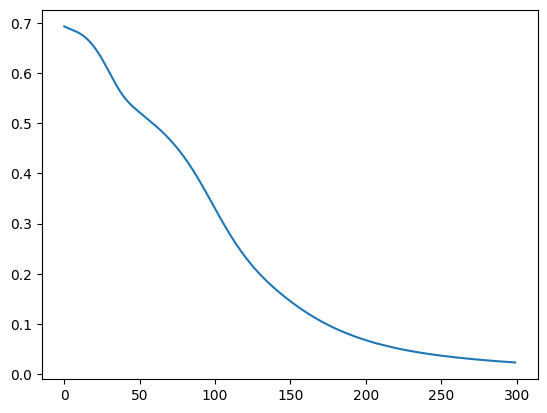

In [9]:
## Define X, Y, train/test split 
X = np.concatenate([X_props_1h, X_states_1h], axis=1)
Y = np.array(Y_labels).astype(float)
Xtr, Xte, ytr, yte = train_test_split(X, Y, test_size=0.2, random_state=0)

## Define model 
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

## Train
Xt = torch.tensor(Xtr, dtype=torch.float32)
yt = torch.tensor(ytr, dtype=torch.float32).unsqueeze(1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for epoch in range(300):
    opt.zero_grad()
    ypred = model(Xt)
    loss = loss_fn(ypred, yt)
    loss.backward()
    opt.step()
    if epoch%50==0: print(epoch, loss.item())
    losses.append(loss.item())

plt.plot(losses);

In [10]:
# Eval 
with torch.no_grad():
    Xtest = torch.tensor(Xte, dtype=torch.float32)
    ytest = torch.tensor(yte, dtype=torch.float32).unsqueeze(1)
    preds = (model(Xtest) > 0.5).float()
    acc = (preds == ytest).float().mean()

print("Test accuracy:", acc.item())

Test accuracy: 0.9933333396911621


# (4) Baby Theorem Prover

In [11]:
testinput = np.concatenate([encode_state(['A', 'C'], ALL_FORMULAS), encode_state(['B'], ALL_FORMULAS)])
torch_input = torch.tensor([testinput], dtype=torch.float32)
test_output = model(torch_input)
print(test_output.item())

7.087450740073109e-06


/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_5274/496936223.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  torch_input = torch.tensor([testinput], dtype=torch.float32)


In [12]:
## Idea: 
## (1) NN is given a state, gives probability of truth for a given formula.
## (2) Each formula is ranked based on the model. 
## (3) Highest rank is 'chosen' (if it agrees with Z3)

example_state = ['A', 'C']
print(nn_score(example_state, 'B', model, ALL_FORMULAS))
print(rank_candidates(example_state, model, ALL_FORMULAS))
print(pick_valid_step(example_state, model, ALL_FORMULAS, 5))

7.087450740073109e-06
[('A&C', 0.9999097585678101), ('A', 0.6111313104629517), ('B&C', 0.5871369242668152), ('A&B', 0.5437766313552856), ('A&D', 0.3944550156593323), ('C', 0.3343035578727722), ('C&D', 0.14188548922538757), ('A|C', 0.08709716796875), ('B->A', 0.0007854372961446643), ('D->C', 0.0007398700690828264), ('~B', 0.0003869869979098439), ('A|D', 0.0003120512410532683), ('A|B', 0.00024245187523774803), ('D->A', 0.00020929994934704155), ('B->C', 0.00017358186596538872), ('~D', 0.0001658311957726255), ('B|C', 4.852643178310245e-05), ('C->A', 3.094419662375003e-05), ('C|D', 2.894509452744387e-05), ('A->C', 1.5944768165354617e-05), ('B->D', 8.620147127658129e-06), ('B', 7.087450740073109e-06), ('B&D', 6.929480150574818e-06), ('B|D', 6.460775693994947e-06), ('D->B', 5.017193871026393e-06), ('A->B', 4.710720077127917e-06), ('D', 4.530865226115566e-06), ('A->D', 2.7331320779921953e-06), ('~C', 1.2836304676966392e-06), ('C->B', 9.529560429655248e-07), ('C->D', 6.545127462231903e-07), ('~

In [13]:
rank_candidates(['A', 'A->B', 'B->C'], model, ALL_FORMULAS)

[('A&C', 0.999984622001648),
 ('B&C', 0.999982476234436),
 ('A&B', 0.9995280504226685),
 ('C', 0.9968627691268921),
 ('A', 0.9862757921218872),
 ('B->C', 0.9706919193267822),
 ('C&D', 0.9657983779907227),
 ('A->B', 0.915716826915741),
 ('A&D', 0.7976185083389282),
 ('B', 0.7872459888458252),
 ('~B', 0.7214261293411255),
 ('A|C', 0.6925217509269714),
 ('B->A', 0.5274873971939087),
 ('A->C', 0.35333606600761414),
 ('D->C', 0.33424094319343567),
 ('B&D', 0.3197585940361023),
 ('D->A', 0.3088032007217407),
 ('~D', 0.3073127865791321),
 ('C->A', 0.2361082285642624),
 ('B|C', 0.22412720322608948),
 ('~A', 0.1547056883573532),
 ('D->B', 0.1460122913122177),
 ('A|D', 0.12746630609035492),
 ('A|B', 0.09158654510974884),
 ('C|D', 0.08498051762580872),
 ('B->D', 0.04246308654546738),
 ('C->B', 0.030230442062020302),
 ('B|D', 0.02726595290005207),
 ('D', 0.009004351682960987),
 ('A->D', 0.005185563582926989),
 ('C->D', 0.003953538369387388),
 ('~C', 0.0020482030231505632)]

In [14]:
def TheoremProver(state, objective, model, ALL_FORMULAS): 
    while objective not in state: 
        winner = pick_valid_step(state, model, ALL_FORMULAS, 10)[0]
        if winner is None: 
            print("No valid step found. Proof failed.")
            return None
        print(f'NN guess : {winner}')
        state.append(winner)
        print(f'New state: {state}')
    print('Proved!')

In [15]:
TheoremProver(['A', 'A->B', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS)


NN guess : A&C
New state: ['A', 'A->B', 'B->C', 'A&C']
NN guess : B&C
New state: ['A', 'A->B', 'B->C', 'A&C', 'B&C']
NN guess : A&B
New state: ['A', 'A->B', 'B->C', 'A&C', 'B&C', 'A&B']
NN guess : B
New state: ['A', 'A->B', 'B->C', 'A&C', 'B&C', 'A&B', 'B']
NN guess : C
New state: ['A', 'A->B', 'B->C', 'A&C', 'B&C', 'A&B', 'B', 'C']
Proved!
NN guess : C&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D']
NN guess : B&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D', 'B&D']
NN guess : D
New state: ['A', 'A->B', 'B->C', 'C->D', 'C&D', 'B&D', 'D']
Proved!


In [16]:
## Very inefficient theorem prover... it's blind to the goal! 

## In our list of random subsets, A->B *always* comes with A, and not necessarily B. 
## So P(B | A, A->B) is small, and P(B | A, A&B) is larger. Therefore when the NN sees 
## A and A->B, it doesn't automatically guess "B". 

## (5) Goal-Conditioned Theorem Prover

In [17]:
## Make sure verify_step_small can parse all tiny steps ... 
print(verify_step_small(['A', 'A->B', 'B->C'], 'B'))
print(verify_step_small(['A', 'A->B', 'B->C'], 'C'))
print(verify_step_small(['A&B'], 'A'))
print(verify_step_small(['A', 'B'], 'A&B'))
print(verify_step_small(['A'], 'A|B'))
print(verify_step_small(['A|B', '~B'], 'A'))

# Can enforce other rules of logic later ... 
print(verify_step_small(['A->B', '~B'], '~A'))
print(verify_step_small(['A|B', 'A->C', 'B->C'], 'C'))

True
False
True
True
True
True
False
False


In [18]:
## Use small steps to find *true* shortest paths for proofs
print(find_shortest_proof(['A', 'A->B', 'B->C'], 'C', ALL_FORMULAS, 5))
print(find_shortest_proof(['A', 'A->B', 'B->C', 'C->A'], 'A&B', ALL_FORMULAS, 5))

['B', 'C']
['B', 'A&B']


In [19]:
## Generate new & improved data (includes steps)

## First just make a new [X_states, X_props] array ... don't have trivial examples. 
total = len(ALL_STATES) * len(ALL_FORMULAS)
print(total)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known_list = list(known)
    all_paths = find_all_shortest_proofs(known_list, ALL_FORMULAS, 5)
    
    for prop in ALL_FORMULAS:
        
        count += 1
        if count % 20000 == 0:
            print(f"{count} / {total} samples done")
            
        # skip if trivial or unreachable
        if prop in known_list: continue
        if prop not in all_paths: continue
        
        path = all_paths[prop]
            
        # append ... 
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(path[0])

            
print(len(X_states), len(X_props))

192000
20000 / 192000 samples done
40000 / 192000 samples done
60000 / 192000 samples done
80000 / 192000 samples done
100000 / 192000 samples done
120000 / 192000 samples done
140000 / 192000 samples done
160000 / 192000 samples done
180000 / 192000 samples done
33089 33089


In [20]:
## Split up Training Data by depth
depths = []
for state, goal in zip(X_states, X_props):
    path = find_shortest_proof(list(state), goal, ALL_FORMULAS, 5)
    depths.append(len(path))

In [21]:
## Define the indices of data with depth = d
indices1 = [i for i, d in enumerate(depths) if d==1]
indices2 = [i for i, d in enumerate(depths) if d==2]
indices3 = [i for i, d in enumerate(depths) if d==3]
indices4 = [i for i, d in enumerate(depths) if d==4]

## Split X_train into 4 groups  
def subset_dataset(idxs):
    Xs = [X_states[i] for i in idxs]  # state
    Xp = [X_props[i]  for i in idxs]  # prop
    Yl = [Y_labels[i] for i in idxs]  # label
    return Xs, Xp, Yl

X1_states, X1_props, Y1 = subset_dataset(indices1)
X2_states, X2_props, Y2 = subset_dataset(indices2)
X3_states, X3_props, Y3 = subset_dataset(indices3)
X4_states, X4_props, Y4 = subset_dataset(indices4)

In [22]:
def OneHotPrepare(X_states, X_props, Y_labels, ALL_FORMULAS):
    
    OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}
    X_props_num = np.array([OneHot_Map[p] for p in X_props])
    Y_labels_num = np.array([OneHot_Map[p] for p in Y_labels])
    
    # one-hot
    X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_num]  # defining a repeating list of I rows ... 
    X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])
    Y_labels_1h = np.eye(len(ALL_FORMULAS))[Y_labels_num]
    
    return [X_states_1h, X_props_1h, Y_labels_1h]

In [23]:
## 4 separate groups of training data
X1_states_1h, X1_props_1h, Y1_labels_1h = OneHotPrepare(X1_states, X1_props, Y1, ALL_FORMULAS)
X2_states_1h, X2_props_1h, Y2_labels_1h = OneHotPrepare(X2_states, X2_props, Y2, ALL_FORMULAS)
X3_states_1h, X3_props_1h, Y3_labels_1h = OneHotPrepare(X3_states, X3_props, Y3, ALL_FORMULAS)
X4_states_1h, X4_props_1h, Y4_labels_1h = OneHotPrepare(X4_states, X4_props, Y4, ALL_FORMULAS)

## Define X1,2,3,4 and Y1,2,3,4
X1 = np.concatenate([X1_states_1h, X1_props_1h], axis=1)
X2 = np.concatenate([X2_states_1h, X2_props_1h], axis=1)
X3 = np.concatenate([X3_states_1h, X3_props_1h], axis=1)
X4 = np.concatenate([X4_states_1h, X4_props_1h], axis=1)

Y1 = np.argmax(Y1_labels_1h, axis=1)
Y2 = np.argmax(Y2_labels_1h, axis=1)
Y3 = np.argmax(Y3_labels_1h, axis=1)
Y4 = np.argmax(Y4_labels_1h, axis=1)

# cumulative concatenations for training
X12  = np.concatenate([X1, X2], axis=0)
Y12  = np.concatenate([Y1, Y2], axis=0)

X123 = np.concatenate([X1, X2, X3], axis=0)
Y123 = np.concatenate([Y1, Y2, Y3], axis=0)

X1234 = np.concatenate([X1, X2, X3, X4], axis=0)
Y1234 = np.concatenate([Y1, Y2, Y3, Y4], axis=0)

In [24]:
print(len(X1), len(X2), len(X3), len(X4))

13985 14978 3127 945


0 3.4720327854156494
200 0.04842154309153557
400 0.0030629385728389025
600 0.0010666199959814548
800 0.0005680330796167254
1000 0.0003556626325007528
1200 0.00024351094907615334
1400 0.0001766203495208174
0 3.466651678085327
200 0.3351684808731079
400 0.12397921085357666
600 0.039865802973508835
800 0.014042897149920464
1000 0.00633139256387949
1200 0.0033502085134387016
1400 0.0020449720323085785
0 3.4609243869781494
200 0.36335650086402893
400 0.13627701997756958
600 0.03457992896437645
800 0.012998154386878014
1000 0.006165107246488333
1200 0.003474573837593198
1400 0.0021823139395564795
0 3.472227096557617
200 0.40359577536582947
400 0.13521406054496765
600 0.03364323824644089
800 0.013279511593282223
1000 0.00663125840947032
1200 0.003815900534391403
1400 0.00242819357663393
0 3.5375425815582275
200 0.006483438890427351
400 0.001027403399348259
600 0.0003959453315474093
800 0.0002084854058921337
1000 0.000127822466311045
1200 8.578311826568097e-05
1400 6.112053233664483e-05
0 3.54

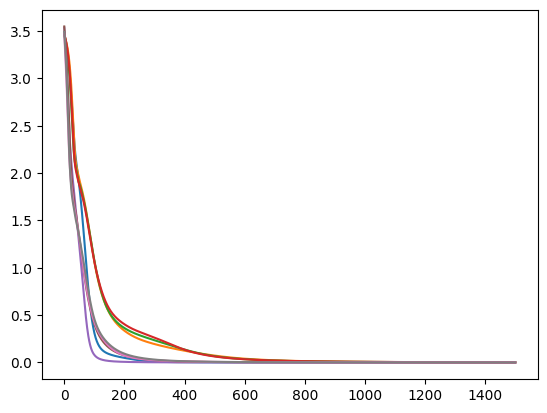

In [27]:
# Train the models 
model1, test1 = train_model(X1,    Y1,    len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model2, test2 = train_model(X12,   Y12,   len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model3, test3 = train_model(X123,  Y123,  len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())
model4, test4 = train_model(X1234, Y1234, len(ALL_FORMULAS), loss_fn=nn.CrossEntropyLoss())

modelDS1, testDS1 = train_model(X1, Y1, len(ALL_FORMULAS), 
                                loss_fn=nn.CrossEntropyLoss(), use_deepsets=True)
modelDS2, testDS2 = train_model(X12, Y12, len(ALL_FORMULAS), 
                                loss_fn=nn.CrossEntropyLoss(), use_deepsets=True)
modelDS3, testDS3 = train_model(X123, Y123, len(ALL_FORMULAS), 
                                loss_fn=nn.CrossEntropyLoss(), use_deepsets=True)
modelDS4, testDS4 = train_model(X1234, Y1234, len(ALL_FORMULAS), 
                                loss_fn=nn.CrossEntropyLoss(), use_deepsets=True)

In [28]:
# ##########################
# ## Train NN on new data ##
# ##########################

# ## Define X, Y, train/test split 
# X = np.concatenate([X_states_1h, X_props_1h], axis=1)
# Y = Y_labels_num
# Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, random_state=0)

# ## Define model 
# model = nn.Sequential(
#                 nn.Linear(X.shape[1], 128), 
#                 nn.ReLU(), 
#                 nn.Linear(128, 64), 
#                 nn.ReLU(), 
#                 nn.Linear(64, len(ALL_FORMULAS)),
# )

# ## Train
# Xt = torch.tensor(Xtr, dtype=torch.float32)
# yt = torch.tensor(Ytr, dtype=torch.long)

# opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = nn.CrossEntropyLoss()

# losses = []
# for epoch in range(1500):
#     opt.zero_grad()
#     loss = loss_fn(model(Xt), yt)
#     loss.backward()
#     opt.step()
#     if epoch%200==0: print(epoch, loss.item())
#     losses.append(loss.item())

# plt.plot(losses);

In [29]:
Xte1, Yte1 = test1
Xte2, Yte2 = test2
Xte3, Yte3 = test3
Xte4, Yte4 = test4

In [30]:
# n_formulas = len(ALL_FORMULAS)

# x = Xte[2]

# state_bits = x[:n_formulas]
# goal_bits  = x[n_formulas:]

# state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
# goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]

# print("state:", state_formulas)
# print("goal:", goal_formula)
# print("label:", Yte[2])


In [31]:
def test_example(num, Xte):
    state_bits = Xte[num][:len(ALL_FORMULAS)]
    goal_bits  = Xte[num][len(ALL_FORMULAS):]
    state_formulas = [ALL_FORMULAS[i] for i, b in enumerate(state_bits) if b == 1]
    goal_formula   = ALL_FORMULAS[np.argmax(goal_bits)]
#     print("state:", state_formulas)
#     print("goal:", goal_formula)
#     print("label:", Yte[2])
    return {'state': state_formulas, 'goal': goal_formula}

In [32]:
test_example(4, Xte3)

{'state': ['A->D', 'C->A', 'B&C', 'A&D'], 'goal': 'B&D'}

## (6) Improved Theorem Prover

In [33]:
# Not even sure if this is in train or test set .... 
state_check = encode_state(['A', 'A->B', 'B->C'], ALL_FORMULAS)
goal_check =  encode_state(['C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model4(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[ -5.8774,  15.3958,   8.5595,   2.6505, -11.3876, -11.8903,  -9.8344,
         -12.6671, -12.6241, -13.2480, -11.4092, -10.6420, -10.8117, -12.2833,
         -12.8781, -11.2415, -11.7650, -11.4922, -12.6869, -12.0015,   1.7268,
          -2.9189,   2.8059,   0.6206,  -2.6179,  -1.6651,  -1.7094,  -9.1366,
           0.2526,  -0.6659, -11.5765,  -7.5062]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [34]:
state_check = encode_state(['A->B', 'A->C', 'D->C', 'B&D'], ALL_FORMULAS)
goal_check =  encode_state(['B|C'], ALL_FORMULAS)
x_check = np.concatenate([state_check, goal_check])
tt = torch.tensor([x_check], dtype=torch.float32)
logits = model2(tt)
print(logits)
print(torch.argmax(logits).item())
print(f'Model guess is {ALL_FORMULAS[torch.argmax(logits).item()]}')

tensor([[  1.8908,  27.0060,   9.9227,   7.4524, -14.2676, -15.2488, -14.8519,
         -15.9911, -13.4292, -15.7826, -12.8105, -15.0524, -13.6271, -12.4594,
         -11.7991, -13.9311, -16.3892, -13.7943, -15.8265, -16.0479,   3.4058,
           7.5315,  -1.9330, -11.1873,  -5.0765,  -7.9692,  -4.2893,  12.7850,
          -7.2745, -15.5212,  -4.0277, -10.1320]], grad_fn=<AddmmBackward0>)
1
Model guess is B


In [35]:
def TheoremProver2(state, objective, model, ALL_FORMULAS): 
    counter = 0
    nF = len(ALL_FORMULAS)
    while objective not in state: 
        counter += 1
        # Encode
        x = np.concatenate([encode_state(state, ALL_FORMULAS), encode_state([objective], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argsort(logits, descending=True)

        # Try top-k predictions (k = 5 is fine)
        chosen = None
        for idx in ranked[:10]:
            guess = ALL_FORMULAS[idx.item()]
            if guess not in state:
                chosen = guess
                break

        # If none available → stuck
        if chosen is None:
            print("Stuck: all top-k guesses were already in state.")
            break

        # Use the chosen formula
        state.append(chosen)
        print("New state:", state)

        if counter > 10:
            print("Giving up after 10 steps.")
            break

    print("Proved!")

In [36]:
# 2 step exapmles 
TheoremProver2(['A', 'A->B', 'B->C'], 'C', model4, ALL_FORMULAS)
TheoremProver2(['A|B', '~A', 'B->C'], 'C', model4, ALL_FORMULAS)
TheoremProver2(['C', 'C->B', 'A'], 'A&B', model4, ALL_FORMULAS)
TheoremProver2(['A->B', 'A->C', 'D->C', 'B&D'], 'B|C', model4, ALL_FORMULAS)
# 3 step examples 
TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model4, ALL_FORMULAS)
TheoremProver2(['A|B', '~B', 'A->C', 'C->D'], 'D', model4, ALL_FORMULAS)
# 4 step examples
# TheoremProver2(['A', 'B', '(A&B)->C', 'C->D'], 'D', model, ALL_FORMULAS)

New state: ['A', 'A->B', 'B->C', 'B']
New state: ['A', 'A->B', 'B->C', 'B', 'C']
Proved!
New state: ['A|B', '~A', 'B->C', 'B']
New state: ['A|B', '~A', 'B->C', 'B', 'C']
Proved!
New state: ['C', 'C->B', 'A', 'B']
New state: ['C', 'C->B', 'A', 'B', 'A&B']
Proved!
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B']
New state: ['A->B', 'A->C', 'D->C', 'B&D', 'B', 'B|C']
Proved!
New state: ['A', 'A->B', 'B->C', 'C->D', 'D']
Proved!
New state: ['A|B', '~B', 'A->C', 'C->D', 'A']
New state: ['A|B', '~B', 'A->C', 'C->D', 'A', 'D']
Proved!


## (7) Faster than Z3 ?  

In [37]:
def TimeToProve(state, goal, model):
    ns_times = []
    bfs_times = []
    for _ in range(100):
        # Neuro-Symbolic
        t0ns = time.time()
        TheoremProver2(state.copy(), goal, model, ALL_FORMULAS)
        t1ns = time.time()
        ns_times.append((t1ns - t0ns) * 1000)

        
        # BFS
        t0bfs = time.time()
        find_shortest_proof(state.copy(), goal, ALL_FORMULAS)
        t1bfs = time.time()
        bfs_times.append((t1bfs - t0bfs) * 1000)

    return [np.mean(ns_times) , np.mean(bfs_times)]

In [38]:
# find some examples that the NN proves correctly, for the time plot
Xtest = Xte4
for n in range(52,55):
    print(f'n is {n}')
    print(len(find_shortest_proof(test_example(n, Xtest)['state'], test_example(n, Xtest)['goal'], ALL_FORMULAS, 4)))
print(test_example(54, Xtest)['state'])
print(test_example(54, Xtest)['goal'])

n is 52
2
n is 53
2
n is 54
3
['A->C', 'A&C', 'B&D', 'C&D']
A&B


In [39]:
# Examples of 1, 2, 3, 4 ! (then plot times below)
TheoremProver2(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model4, ALL_FORMULAS)
TheoremProver2(['C', '~D', 'D->A', 'A&B'], 'A&C', model4, ALL_FORMULAS)
TheoremProver2(['A&C', 'C&D', 'A|B', 'B|C'], 'A&D', model4, ALL_FORMULAS)
TheoremProver2(['A->D', 'B->D', 'B&C'], 'C&D', model4, ALL_FORMULAS)
# TheoremProver2(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS) ## not sure if its in test set

New state: ['B', 'C&D', 'B|C', 'A|D', 'B|D']
Proved!
New state: ['C', '~D', 'D->A', 'A&B', 'A']
New state: ['C', '~D', 'D->A', 'A&B', 'A', 'A&C']
Proved!
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A']
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A', 'D']
New state: ['A&C', 'C&D', 'A|B', 'B|C', 'A', 'D', 'A&D']
Proved!
New state: ['A->D', 'B->D', 'B&C', 'B']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C', 'D']
New state: ['A->D', 'B->D', 'B&C', 'B', 'C', 'D', 'C&D']
Proved!


In [40]:
import contextlib, os
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    times0 = TimeToProve(['B', 'C&D', 'B|C', 'A|D'], 'B|D', model4)
    times1 = TimeToProve(['B', 'D', 'B->D', 'C&D'], 'A|C', model4)
    times2 = TimeToProve(['~A', 'C&D', 'A|B', 'B|D'], 'B&D', model4)
    times3 = TimeToProve(['B', 'A->C', 'A&D'], 'C&D', model4)

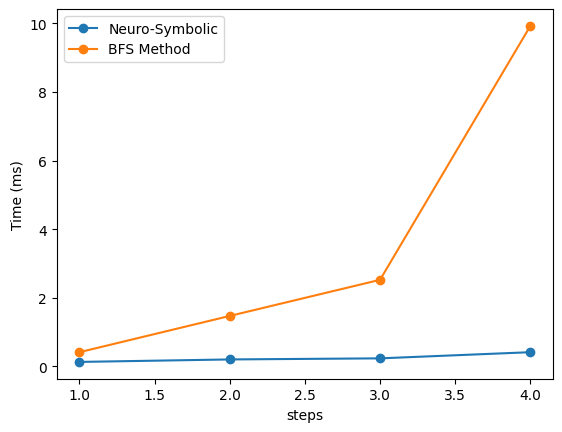

In [41]:
plt.plot([1, 2, 3, 4], [times0[0], times1[0], times2[0], times3[0]], marker='o')
plt.plot([1, 2, 3, 4], [times0[1], times1[1], times2[1], times3[1]], marker='o');
##~~~~ NN failed for steps = 4 ~~~~~~~~
# plt.scatter(4, times3[0], marker='x', color='red', s=100)
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.ylabel('Time (ms)')
plt.xlabel('steps')
plt.legend(['Neuro-Symbolic', 'BFS Method'])

## (8) Overall Accuracy

In [42]:
def prove_with_nn(state, goal, model, ALL_FORMULAS, max_steps=5):
    '''
    Given state, goal ... try to prove goal with NN.  
    Returns True if successful 
    Returns False if not
    '''
    state = list(state)
    
    # True shortest depth
    true_path = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
    if true_path is None: return False
    true_depth = len(true_path)
    
    steps_taken = 0

    for _ in range(max_steps):
        if goal in state:
            return steps_taken==true_depth  

        # encode, rank predictions
        x = np.concatenate([encode_state(state, ALL_FORMULAS),encode_state([goal], ALL_FORMULAS)])
        tt = torch.tensor([x], dtype=torch.float32)
        logits = model(tt)[0]
        ranked = torch.argmax(logits).item()  # most likely next step

        f = ALL_FORMULAS[ranked]

        if f in state or not verify_step_small(state, f): 
            return False

        state.append(f)
        steps_taken+=1

    return False  # max steps reached


In [45]:
def final_check_NN(Xtest, model):
    def get_test_case(i):
        state = test_example(i, Xtest)['state']
        goal = test_example(i, Xtest)['goal']
        return state, goal

    correct = 0
    total = len(Xtest)

    for i in range(total):
        state, goal = get_test_case(i)
        if prove_with_nn(state, goal, model, ALL_FORMULAS): # if NN can prove goal ... 
            correct += 1

    print("Global Proof Accuracy:", correct, "/", total, "=", correct/total)

final_check_NN(Xte1, model1)
final_check_NN(Xte2, model2)
final_check_NN(Xte3, model3)
final_check_NN(Xte4, model4)
final_check_NN(Xte2, modelDS2)
final_check_NN(Xte3, modelDS3)
final_check_NN(Xte4, modelDS4)

Global Proof Accuracy: 2797 / 2797 = 1.0
Global Proof Accuracy: 5768 / 5793 = 0.9956844467460728
Global Proof Accuracy: 6306 / 6418 = 0.9825490807105017
Global Proof Accuracy: 6389 / 6607 = 0.9670046919933404
Global Proof Accuracy: 5766 / 5793 = 0.9953392024857587
Global Proof Accuracy: 6303 / 6418 = 0.9820816453723902
Global Proof Accuracy: 6380 / 6607 = 0.9656425003783866


In [47]:
def accuracy_by_depth(Xte, model, ALL_FORMULAS):
    results = {}
    true_depths = []

    for i in range(len(Xte)):
        state, goal = test_example(i, Xte)['state'], test_example(i, Xte)['goal']
        path  = find_shortest_proof(state, goal, ALL_FORMULAS, 5)
        true_depths.append(len(path))
    depths = sorted(set(true_depths))

    for d in depths:
        idxs = [i for i,depth in enumerate(true_depths) if depth == d]
        if len(idxs) == 0:
            continue
            
    
        correct = 0
        for i in idxs:
            state, goal = test_example(i, Xte)['state'], test_example(i, Xte)['goal']
            if prove_with_nn(state, goal, model, ALL_FORMULAS):
                correct += 1

        results[d] = correct / len(idxs)

    return results

In [61]:
acc1 = accuracy_by_depth(Xte4, model1, ALL_FORMULAS)
acc2 = accuracy_by_depth(Xte4, model2, ALL_FORMULAS)
acc3 = accuracy_by_depth(Xte4, model3, ALL_FORMULAS)
acc4 = accuracy_by_depth(Xte4, model4, ALL_FORMULAS)
print(acc1)
print(acc2)
print(acc3)
print(acc4)

{1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}
{1: 1.0, 2: 0.9907468605419696, 3: 0.6120826709062003, 4: 0.0}
{1: 1.0, 2: 0.991407799074686, 3: 0.8696343402225755, 4: 0.5714285714285714}
{1: 0.9989196975153043, 2: 0.988433575677462, 3: 0.8124006359300477, 4: 0.6457142857142857}


In [62]:
accDS1 = accuracy_by_depth(Xte4, modelDS1, ALL_FORMULAS)
accDS2 = accuracy_by_depth(Xte4, modelDS2, ALL_FORMULAS)
accDS3 = accuracy_by_depth(Xte4, modelDS3, ALL_FORMULAS)
accDS4 = accuracy_by_depth(Xte4, modelDS4, ALL_FORMULAS)
print(accDS1)
print(accDS2)
print(accDS3)
print(accDS4)

{1: 1.0, 2: 0.005948446794448116, 3: 0.003179650238473768, 4: 0.005714285714285714}
{1: 0.9996398991717681, 2: 0.9943820224719101, 3: 0.6550079491255962, 4: 0.4057142857142857}
{1: 0.9996398991717681, 2: 0.991407799074686, 3: 0.8871224165341812, 4: 0.6457142857142857}
{1: 0.9992797983435362, 2: 0.9834765366820886, 3: 0.8203497615262321, 4: 0.6457142857142857}


In [63]:
accs = [acc1, acc2, acc3, acc4]
accsDS = [accDS1, accDS2, accDS3, accDS4]
labels = ["Depth ≤1", "Depth ≤2", "Depth ≤3", "Depth ≤4"]

# Collect union of depths that appear
all_depths = sorted(set().union(
    *[acc.keys() for acc in accs],
    *[acc.keys() for acc in accsDS],
))
print(all_depths)

[1, 2, 3, 4]


[[1.         0.         0.         0.        ]
 [1.         0.99074686 0.61208267 0.        ]
 [1.         0.9914078  0.86963434 0.57142857]
 [0.9989197  0.98843358 0.81240064 0.64571429]]
[[1.         0.00594845 0.00317965 0.00571429]
 [0.9996399  0.99438202 0.65500795 0.40571429]
 [0.9996399  0.9914078  0.88712242 0.64571429]
 [0.9992798  0.98347654 0.82034976 0.64571429]]


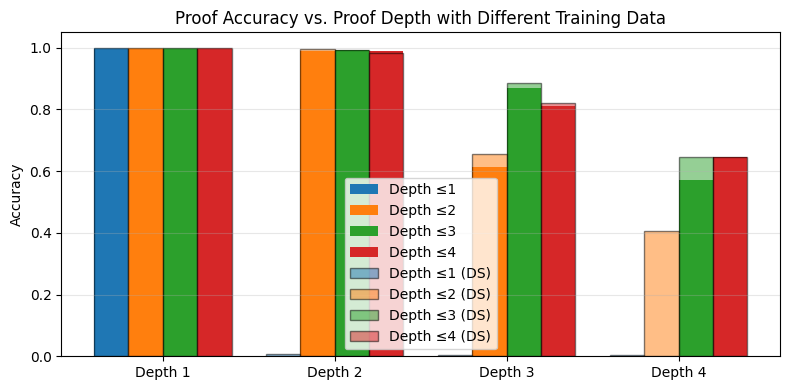

In [71]:
data = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accs])
data_DS = np.array([[acc.get(d, np.nan) for d in all_depths] for acc in accsDS])

print(data)
print(data_DS)


# --- Plot ---
x = np.arange(len(all_depths))            # depth positions
width = 0.2                               # bar width

plt.figure(figsize=(8,4))
bars = []
for i in range(len(accs)):
    b = plt.bar(x + i*width, data[i], width, label=labels[i])
    bars.append(b)

for i in range(len(accsDS)):
    c = bars[i].patches[0].get_facecolor()   # RGBA color used for set i
    plt.bar(x + i*width, data_DS[i], width,
            label=labels[i] + " (DS)",
            facecolor=c, edgecolor='k', alpha=0.5, linewidth=1)
    
plt.xticks(x + width*1.5, [f"Depth {d}" for d in all_depths])
plt.ylabel("Accuracy")
plt.ylim(0,1.05)
plt.legend(loc='lower center')
plt.title("Proof Accuracy vs. Proof Depth with Different Training Data")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
